**Building a Quantum Random Number Generator (QRNG)**
Multiple methods are used to build QRNG's in industry and today we will build a primitive one using just one Hadamard Gate, i.e, the H Gate on a simulator.

First, let's import what we require from qiskit:

In [3]:
pip install qiskit


     |████████████████████████████████| 6.0MB 3.9MB/s 
     |████████████████████████████████| 17.9MB 212kB/s 
     |████████████████████████████████| 204kB 47.9MB/s 
     |████████████████████████████████| 215kB 44.5MB/s 
     |████████████████████████████████| 2.1MB 36.5MB/s 
     |████████████████████████████████| 1.0MB 29.8MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 194kB 49.8MB/s 
     |████████████████████████████████| 81kB 6.2MB/s 
     |████████████████████████████████| 614kB 45.8MB/s 
     |████████████████████████████████| 3.2MB 37.7MB/s 
     |████████████████████████████████| 5.5MB 48.5MB/s 
  Created wheel for qiskit: filename=qiskit-0.25.0-cp37-none-any.whl size=3032 sha256=2e5f4c06149a9d8bdc95095e1783ad3cf9f9555286ede736b34520cea8f16999
  Stored in directory: /root/.cache/pip/wheels/09/6e/f1/a7eaab6e3943d749f1b257f462f60fbc402b0c8e870b555169
  Created wheel for python-constraint: filename=python_constraint-1.4.0-py2

In [4]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

You can ignore the next two lines of code. This will be required when you want to try the QRNG you build on a real device. We'll get to that later.

In [5]:
# IBMQ.save_account('YOUR_IBM_TOKEN') # you can find your account id on the IBm Quantum Experience website
                                       # in your profile section 

In [6]:
# provider = IBMQ.load_account()

In [7]:
q2 = QuantumRegister(1)
c2 = ClassicalRegister(1)
qc2 = QuantumCircuit(q2, c2)
qc2.draw()

q0_0: 
      
c0: 1/

Now apply a hadamard gate to put the first qubit into a |+⟩ state. Where,
             1+>=|0> + |1>
                 ---------
                    √2

In [8]:
qc2.h(0)
qc2.draw()

┌───┐
q0_0: ┤ H ├
      └───┘
c0: 1/═════

We only get results when we measure the qubit and then read that clasical data, which in our case is then store in our classical register c2.

In [9]:
qc2.measure(q2[0], c2[0])
qc2.draw()

┌───┐┌─┐
q0_0: ┤ H ├┤M├
      └───┘└╥┘
c0: 1/══════╩═
            0

In [18]:
# running and getting results 

backend = Aer.get_backend('qasm_simulator')
job = execute(qc2, backend, shots=100)
# backend = provider.get_backend('ibmq_qasm_simulator')
# job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})
result = job.result()
count = result.get_counts()
print(count)

{'1': 46, '0': 54}


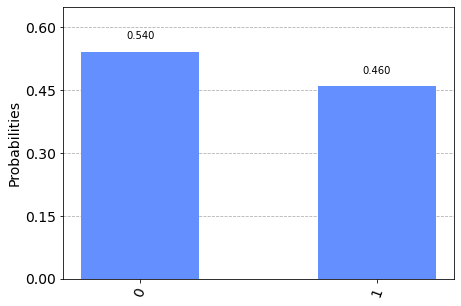

In [19]:
plot_histogram(count)

If we re-run the above cell we randomly get the value 0 and 1. We've created a random number generator!

**Grover's Algorithm for 4 qubits(ex: finding the entry 1010)**

Building our circuit and equal superposition initialization
Let's build our circuit with 7 qubits

4 qubits for input
1 qubit for storing the |-> state
2 ancilla qubits (as will be explained bellow)
And our answer will be stored in a classical register of size 4

Further, we intialize our input in an equal superposition of all possible states

In [11]:
q = QuantumRegister(7)
c = ClassicalRegister(4)
qc = QuantumCircuit(q, c)

In [20]:
# initialize in a superposition of all possible states 
qc.x(q[4])
qc.h(q[0:5])
qc.barrier(q)

In [21]:
qc.barrier(q)

# build oracle. ex: to find 1010 state
qc.x(q[1])
qc.x(q[3])
qc.barrier(q)
qc.mct([q[0], q[1], q[2], q[3]], q[4], q[5:7])    # control qubits, target qubit, ancilla qubits = number of control qubits - 2
qc.barrier(q)
qc.x(q[1])
qc.x(q[3])

qc.barrier(q)

**Amplitude Amplification (Diffusion Operator)**
this is equivalent to flip about the mean operation geometrically. Also known as the amplitude amplification step as we are increasing the amplitudes(probability) of the entries that we flipped(gave a - phase to) in the previou step while applying our oracle.

In [22]:
qc.barrier(q)
qc.h(q[0:4])
qc.barrier(q)
qc.x(q[0:4])
qc.barrier(q)
qc.h(q[3])
qc.barrier(q)
qc.mct([q[0], q[1], q[2]], q[3], q[5:6])   
qc.barrier(q)
qc.h(q[3])
qc.barrier(q)
qc.x(q[0:4])
qc.barrier(q)
qc.h(q[0:4])
qc.barrier(q)

In [23]:
qc.measure(q[0:4], c[0:4])

In [24]:
qc.draw()

# in the output drawing 

┌───┐      ░  ░       ░       ░       ░  ░ ┌───┐ ░ ┌───┐ ░       ░      »
q5_0: ┤ H ├──────░──░───────░───■───░───────░──░─┤ H ├─░─┤ X ├─░───────░───■──»
      ├───┤      ░  ░ ┌───┐ ░   │   ░ ┌───┐ ░  ░ ├───┤ ░ ├───┤ ░       ░   │  »
q5_1: ┤ H ├──────░──░─┤ X ├─░───■───░─┤ X ├─░──░─┤ H ├─░─┤ X ├─░───────░───■──»
      ├───┤      ░  ░ └───┘ ░   │   ░ └───┘ ░  ░ ├───┤ ░ ├───┤ ░       ░   │  »
q5_2: ┤ H ├──────░──░───────░───■───░───────░──░─┤ H ├─░─┤ X ├─░───────░───■──»
      ├───┤      ░  ░ ┌───┐ ░   │   ░ ┌───┐ ░  ░ ├───┤ ░ ├───┤ ░ ┌───┐ ░ ┌─┴─┐»
q5_3: ┤ H ├──────░──░─┤ X ├─░───■───░─┤ X ├─░──░─┤ H ├─░─┤ X ├─░─┤ H ├─░─┤ X ├»
      ├───┤┌───┐ ░  ░ └───┘ ░ ┌─┴─┐ ░ └───┘ ░  ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘»
q5_4: ┤ X ├┤ H ├─░──░───────░─┤ X ├─░───────░──░───────░───────░───────░──────»
      └───┘└───┘ ░  ░       ░ └───┘ ░       ░  ░       ░       ░       ░      »
q5_5: ───────────░──░───────░───────░───────░──░───────░───────░───────░──────»
                 ░  ░       ░       ░       ░  ░       ░       ░       ░      »
q5_6: ───────────░──░───────░───────░───────░──░───────░───────░───────░──────»
                 ░  ░       ░       ░       ░  ░       ░       ░       ░      »
c1: 4/════════════════════════════════════════════════════════════════════════»
                                                                              »
«       ░       ░ ┌───┐ ░ ┌───┐ ░ ┌─┐         
«q5_0: ─░───────░─┤ X ├─░─┤ H ├─░─┤M├─────────
«       ░       ░ ├───┤ ░ ├───┤ ░ └╥┘┌─┐      
«q5_1: ─░───────░─┤ X ├─░─┤ H ├─░──╫─┤M├──────
«       ░       ░ ├───┤ ░ ├───┤ ░  ║ └╥┘┌─┐   
«q5_2: ─░───────░─┤ X ├─░─┤ H ├─░──╫──╫─┤M├───
«       ░ ┌───┐ ░ ├───┤ ░ ├───┤ ░  ║  ║ └╥┘┌─┐
«q5_3: ─░─┤ H ├─░─┤ X ├─░─┤ H ├─░──╫──╫──╫─┤M├
«       ░ └───┘ ░ └───┘ ░ └───┘ ░  ║  ║  ║ └╥┘
«q5_4: ─░───────░───────░───────░──╫──╫──╫──╫─
«       ░       ░       ░       ░  ║  ║  ║  ║ 
«q5_5: ─░───────░───────░───────░──╫──╫──╫──╫─
«       ░       ░       ░       ░  ║  ║  ║  ║ 
«q5_6: ─░───────░───────░───────░──╫──╫──╫──╫─
«       ░       ░       ░       ░  ║  ║  ║  ║ 
«c1: 4/════════════════════════════╩══╩══╩══╩═
«                                  0  1  2  3

In case you would like to learn more about how the mct() gate, i.e, the multiple controlled toffoli gate is decomposed you can check out section this paper

Checking our results after running it on a simulator
Note that we have not yet used a real quantum computer as they as noisy. We could however do so by changing our provider from 'ibmq_qasm_simulator' to the hardware backend you like.

In [25]:
# running and getting results 

backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
# backend = provider.get_backend('ibmq_qasm_simulator')
# job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})
result = job.result()
count = result.get_counts()
print(count)

{'1110': 31, '1000': 31, '0010': 29, '1011': 35, '0100': 39, '0110': 36, '1101': 37, '0011': 30, '0000': 43, '0111': 38, '1100': 35, '0101': 480, '0001': 39, '1001': 37, '1010': 33, '1111': 27}


In [26]:
# the code snippet below can be used to retreive your job in case your jupyter notebook loses connection with IBMQ servers before completion of the job

# backend = provider.get_backend('ibmq_qasm_simulator')
# job = backend.retrieve_job('enter your job id here. it can be found in your IBM Q Experience dashboard')
# counts = job.result().get_counts()
# print(counts)

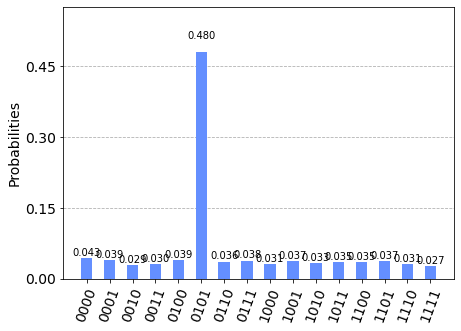

In [27]:
plot_histogram(count)

# the answer may seem inverted, i.e, 0101 is actually state 1010. that's just the notation used by qiskit.

We can see that the entry 1010 has a higher probability of appearing as compared to all the other entries. Note that we have only done the grover method once and yet got a decent answer. I encourage you to try and iterate this method multiple times to see the increase or decrease in probability. For a larger qubit number we may have to do this multiple times to get a decent probability.

However, if you cross a certain number of iterations the amplitude of the expected states starts to come down again. This is depicted in the link here through this diagram for 2 and 10 qubits. Thus, the number of iterations 𝑁⎯⎯⎯⎯√ is usually a good number to stick to in the case of a single search item. If you are searching for "m" items then the number of iterations you'll have to do decreases to √(N/m)